In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
import json
import numpy as np
from format_data import *
from utils import *
import pickle
import math
from delta_frequency import *

t_pre = 0.5#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)

In [1]:
session = 'ALTAI_20240806_SESSION_00'
path = '/Volumes/data2/eTheremin/ALTAI/'+ session + '/'

In [33]:
data = np.load(path+'headstage_0/data_0.005.npy', allow_pickle=True)
features = np.load(path+'headstage_0/features_0.005.npy', allow_pickle=True)
gc = np.load(path+'headstage_0/good_clusters.npy', allow_pickle=True) 
#gc = np.arange(32)

In [35]:
features

array([{'Played_frequency': 0.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False},
       {'Played_frequency': 0.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False},
       {'Played_frequency': 0.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False},
       ...,
       {'Played_frequency': 460.0, 'Condition': 0.0, 'Block': 6.0, 'Frequency_changes': False},
       {'Played_frequency': 460.0, 'Condition': 0.0, 'Block': 6.0, 'Frequency_changes': False},
       {'Played_frequency': 460.0, 'Condition': 0.0, 'Block': 6.0, 'Frequency_changes': False}],
      dtype=object)

In [34]:
mock_psth = get_mock_psth(data, features, t_pre, t_post, bin_width, gc)

KeyError: 'Mock_change'

In [ ]:
psth, delta_f = get_delta_f(data, features, t_pre, t_post, bin_width, gc)

/Users/felicie/analysebingobike/delta_frequency.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  diff = math.log2(features[bin]['Played_frequency']/features[bin]['Mock_frequency'])


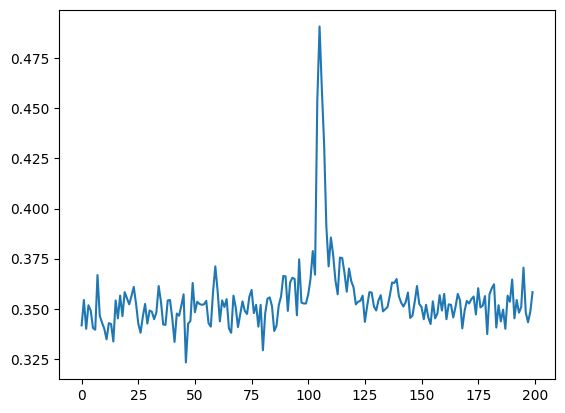

In [26]:
plt.plot(np.nanmean(psth[7], axis=0))

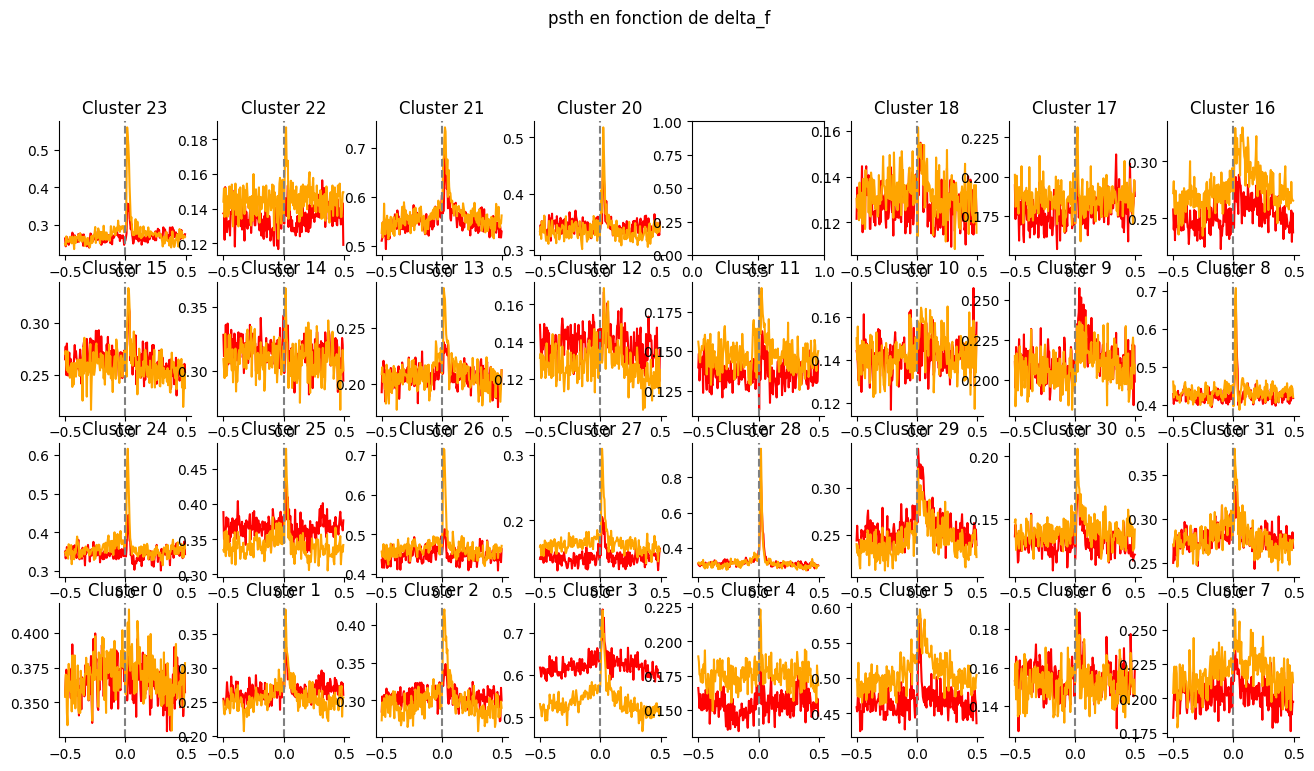

In [31]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('psth en fonction de delta_f', y=1.02)
plt.subplots_adjust() 
delta_f = np.array(delta_f)
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)
psth_bins = np.arange(-t_pre, t_post, bin_width)
for n, cluster in enumerate(gc):
    if n < num_plots:
        clus = np.array(psth[n])
        psth_0_1 = clus[(delta_f >= 0) & (delta_f < 2)]
        #psth_1_3 = clus[(delta_f >= 1) & (delta_f < 3)]
        psth_3_plus = clus[delta_f >= 1]
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(psth_0_1, axis=0), c = 'red')
        #axes[row, col].plot(psth_bins, np.nanmean(psth_1_3, axis=0), c = 'purple')
        axes[row, col].plot(psth_bins, np.nanmean(psth_3_plus, axis=0), c = 'orange')
        axes[row, col].axvline(0, c = 'grey', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')
        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)

In [27]:
clus = np.array(psth[7])

delta_f = np.array(delta_f)
psth_0_1 = clus[(delta_f >= 0) & (delta_f < 1)]
psth_1_2 = clus[(delta_f >= 1) & (delta_f < 2)]
psth_2_3 = clus[(delta_f >= 2) & (delta_f < 3)]
psth_3_plus = clus[delta_f >= 3]

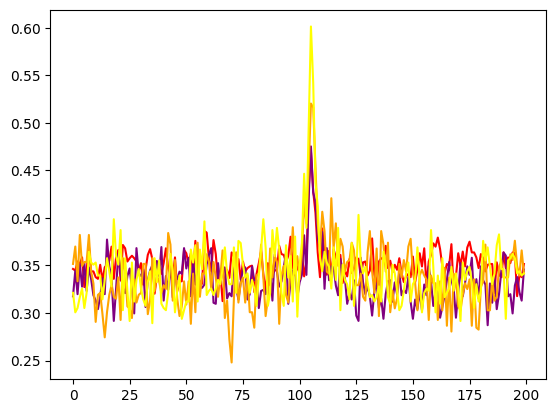

In [28]:
plt.plot(np.nanmean(psth_0_1, axis=0), c = 'red')
plt.plot(np.nanmean(psth_1_2, axis=0), c = 'purple')
plt.plot(np.nanmean(psth_2_3, axis=0), c = 'orange')
plt.plot(np.nanmean(psth_3_plus, axis=0), c = 'yellow')

In [12]:
psth, delta_f  = get_delta_f(data, features, t_pre, t_post, bin_width, gc)

/Users/felicie/analysebingobike/delta_frequency.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  diff = math.log2(features[bin]['Played_frequency']/features[bin]['Mock_frequency'])


In [3]:
import pickle

# Path to your .pkl file
file_path = path + 'headstage_0/tt.pkl'

# Load the pickle file
with open(file_path, "rb") as file:
    tt = pickle.load(file)

In [4]:
tt

{'tones': array([828., 959., 828., ..., 343., 397., 343.]),
 'triggers': [109821,
  110301,
  110541,
  114461,
  114621,
  115221,
  118581,
  118781,
  120261,
  120461,
  120621,
  120821,
  121061,
  121941,
  122301,
  138621,
  144621,
  153621,
  154421,
  156821,
  157061,
  161741,
  171101,
  175421,
  178781,
  183621,
  184941,
  193781,
  196581,
  207821,
  208221,
  209141,
  211941,
  230301,
  262781,
  265781,
  268061,
  271061,
  275741,
  293541,
  293741,
  294101,
  309101,
  313061,
  319061,
  334581,
  338301,
  341741,
  341901,
  342261,
  342821,
  367941,
  382221,
  390461,
  390621,
  390821,
  391061,
  391421,
  392301,
  398141,
  409061,
  413901,
  439421,
  472061,
  478781,
  481221,
  483261,
  485541,
  487221,
  489821,
  492261,
  536901,
  539301,
  541421,
  562781,
  564821,
  568781,
  577581,
  602741,
  605301,
  606621,
  607581,
  608301,
  609101,
  609621,
  610421,
  611301,
  612101,
  612621,
  613581,
  614301,
  620141,
  620381

In [5]:
print(len(tt['mock_tones']), len(tt['mock_triggers']))

6199 3522
